In [197]:
import sys
sys.path.append('..')
import utils

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

from utils import one_hot
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

In [2]:
def hamming(x:torch.tensor, y: torch.tensor):
    L = x.size(-2)
    return L - (x * y).sum((-2, -1)).to(torch.int)

In [3]:
dtype = torch.float32

In [4]:
tr = tree.Tree()
tr.add_node(-1, name = "round 1 with selection")
tr.add_node(0, name = "round 2 with selection")

selected_modes = torch.BoolTensor(
    [[1, 0],
     [1, 0]]
)

n_selection_rounds, n_modes = selected_modes.size()
assert n_selection_rounds == tr.get_n_nodes()
n_rounds = n_selection_rounds + 1

In [251]:
L, q = 45, 4

In [253]:
generator = torch.Generator().manual_seed(1)
h_teacher = torch.randn(L, q, dtype=dtype, generator=generator)
wt_oh = sampling.sample_indep_sites(h_teacher, n_samples=1, generator=generator, beta=1.0).squeeze()
mutation_rate = 0.1
k_teacher = utils.field_from_wildtype(wt_oh, mutation_rate)
Ns0_teacher = energy_models.IndepSites(k_teacher)
sel_teacher = energy_models.IndepSites(h_teacher)
# sel.normalize()
unbound = energy_models.ConstantEnergy(-25.0)
ps_teacher = selex_distribution.MultiModeDistribution(sel_teacher, unbound, normalized=True)
model_teacher = selex_distribution.MultiRoundDistribution(Ns0_teacher, ps_teacher, tr, selected_modes)
model_teacher.train(mode=False);

## More accurate sampling

In [254]:
sample_round_zero = lambda n: sampling.sample_indep_sites(k_teacher, n)
def ps_round_t(x, t):
    return torch.exp(-ps_teacher.compute_energy(x, selected_modes[t]).detach())

total_reads = torch.tensor([0, 1, 2]) + 10**6
initial_pop_size = 10**7

In [255]:
# seq_round_zero = sample_round_zero(initial_pop_size)
# sequences, counts_round_zero = torch.unique(seq_round_zero, dim=0, return_counts=True)

In [258]:
def sample_realistic(
    sample_round_zero,
    ps_round_t,
    initial_pop_size: int,
    total_reads: torch.tensor,
    population = [],
    verbose = True
):
    seq_round_zero = sample_round_zero(initial_pop_size)
    if verbose: print("Extracting unique sequences and counts from initial library...")
    sequences, counts_round_zero = torch.unique(seq_round_zero, dim=0, return_counts=True)
    ps = [ps_round_t(sequences, t) for t in range(n_selection_rounds)]
    if not torch.all(torch.tensor([torch.all(pst <= 1) for pst in ps])):
        raise ValueError(f'Got some selection probabilities > 1')
    population.append(counts_round_zero.to(torch.int64))
    for t in range(1, n_rounds):
        if verbose: print(f"Starting selection round {t} of {n_rounds-1}...")
        d = torch.distributions.Binomial(population[t-1], ps[t-1])
        selected = d.sample()
        if not torch.all(selected >= 0):
            raise ValueError("Binomial sampled negative values")
        amplification = 1 / ps[t-1].mean()
        population_t = (selected * amplification).to(torch.int64)
        if not torch.all(population_t >= 0):
            raise ValueError("Negative population value")
        if torch.all(population_t == 0):
            raise ValueError(f"Nothing was selected at round {t}")
        population.append(population_t)
    reads_idx = []
    for t in range(n_rounds):
        reads_t = torch.multinomial(population[t].to(dtype), total_reads[t], replacement=True)
        reads_idx.append(reads_t)
    sequences_oh = [sequences[id] for id in reads_idx]
    
    return sequences, population, sequences_oh

In [259]:
population = []
sequences, population, sequences_oh = sample_realistic(
    sample_round_zero,
    ps_round_t,
    initial_pop_size,
    total_reads,
    population
)

Extracting unique sequences and counts from initial library...
Starting selection round 1 of 2...
Starting selection round 2 of 2...


In [260]:
idx = population[1].argmax(0).item()
hamming(sequences[idx], wt_oh)

tensor(1, dtype=torch.int32)

In [261]:
[pop.to(dtype).mean() for pop in population]

[tensor(1.4412), tensor(1.4253), tensor(113.2684)]

In [262]:
# torch.unique(population[0], return_counts=True)

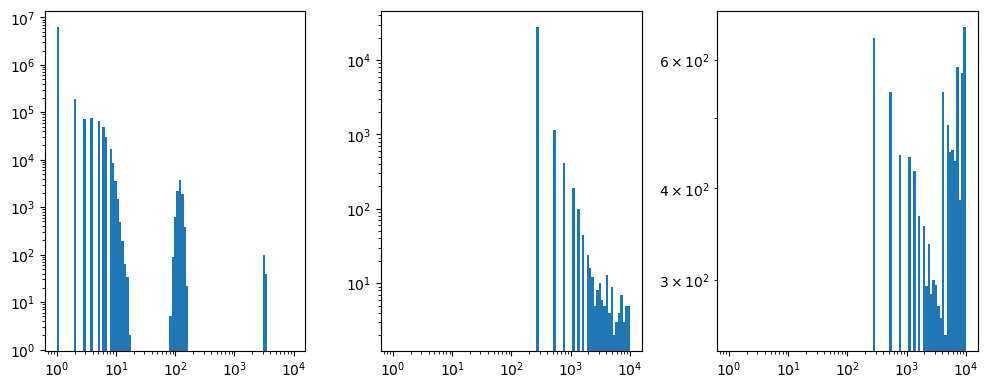

In [263]:
fig, axes = plt.subplots(1, n_rounds, figsize=(10,4))

for t in range(n_rounds):
    ax = axes[t]
    ax.hist(population[t], bins=np.logspace(0, 4, 100))
    ax.set_yscale('log')
    ax.set_xscale('log')

fig.tight_layout()

## Learn

In [264]:
k = torch.randn(L, q, dtype=dtype)
h = torch.randn(L, q, dtype=dtype)

Ns0 = energy_models.IndepSites(k)
sel = energy_models.IndepSites(h)
ps = selex_distribution.MultiModeDistribution(sel, unbound, normalized=True)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

In [265]:
batch_size = 10**5
data_loaders = [data_loading.SelexRoundDataLoader(sequences_oh[id], batch_size=batch_size, device=torch.device('cpu')) 
                for id in range(n_rounds)]

In [266]:
n_chains = 10**4
chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype)

In [269]:
callbacks = [callback.ConvergenceMetricsCallback(), callback.TeacherStudentCallback(model_teacher)]

In [353]:
n_sweeps = 10
lr = 0.1
target_pearson = 1
max_epochs = 2000

training.train(model, data_loaders, total_reads, chains, n_sweeps, max_epochs, target_pearson, 
               lr=lr, callbacks=callbacks, log_weights=log_weights)

 0.00%[                                                                                                       …

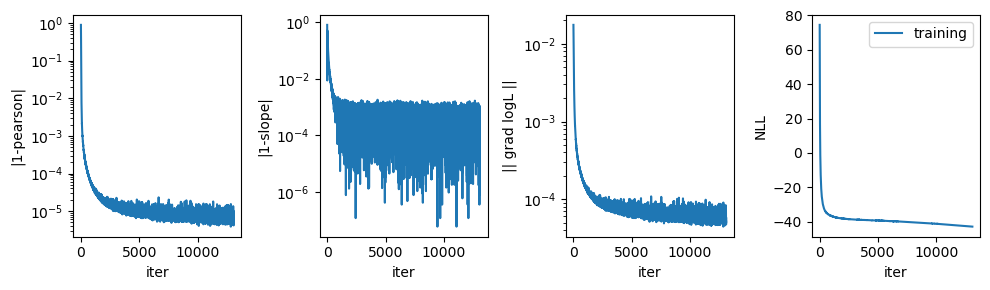

In [354]:
callbacks[0].plot();

INDEP SITES


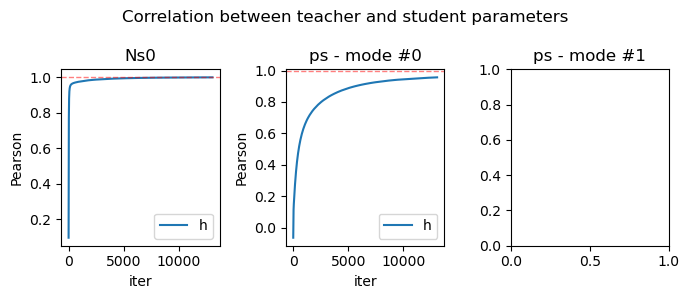

In [355]:
callbacks[1].plot(figsize=(7,3))
print('INDEP SITES')

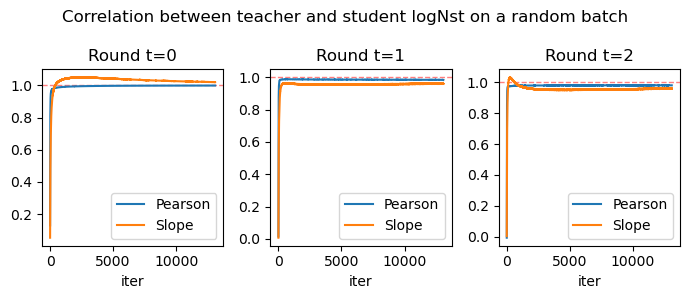

In [356]:
callbacks[1].plot_pearson_energies(figsize=(7,3));

0.9985924363136292

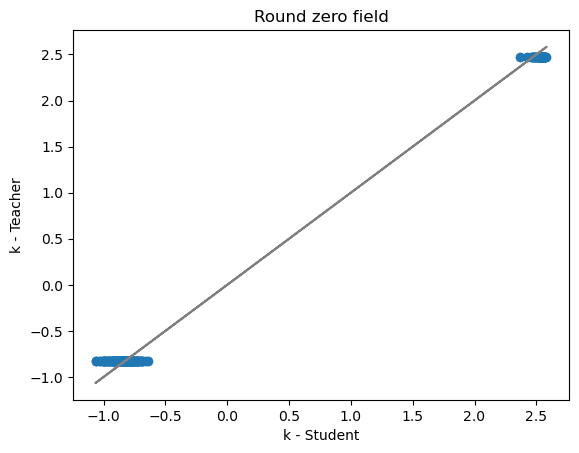

In [357]:
X = model.round_zero.set_zerosum_gauge().h.detach().reshape(-1)
Y = model_teacher.round_zero.set_zerosum_gauge().h.detach().reshape(-1)
plt.scatter(X, Y)
plt.plot(X, X, color='gray')
plt.xlabel('k - Student'); plt.ylabel('k - Teacher')
plt.title('Round zero field')
utils.compute_pearson(X, Y)

0.9568443894386292

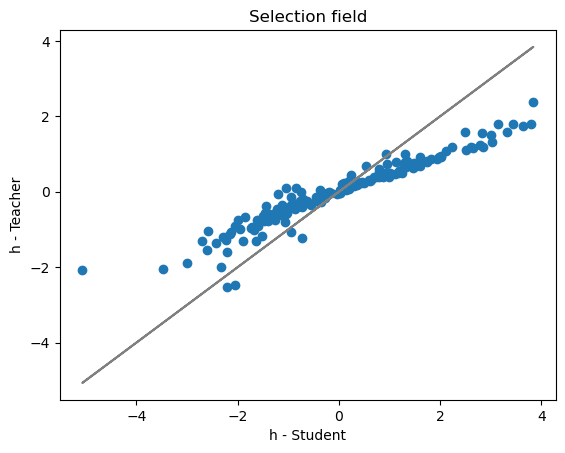

In [358]:
X = model.selection.modes[0].set_zerosum_gauge().h.detach().reshape(-1)
Y = model_teacher.selection.modes[0].set_zerosum_gauge().h.detach().reshape(-1)
plt.scatter(X, Y)
plt.plot(X, X, color='gray')
plt.xlabel('h - Student'); plt.ylabel('h - Teacher')
plt.title('Selection field')
utils.compute_pearson(X, Y)

## Compare against data

In [359]:
# sequences_unique_all_oh, counts_unique, enrichments = utils.unique_sequences_counts_enrichments(sequences_oh)

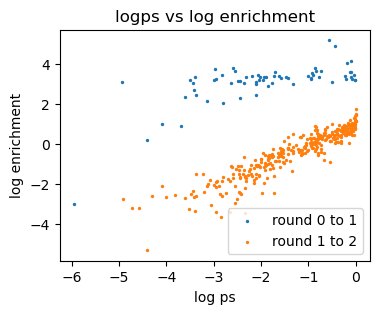

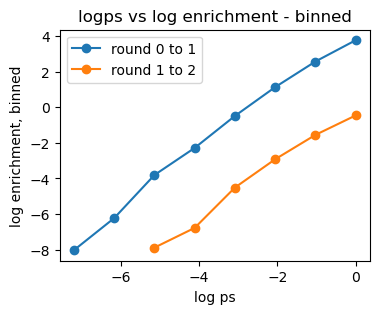

In [360]:
utils.binned_logenrichments(model, sequences_unique_all_oh, enrichments, counts_unique, n_bins = 25, plot=True, thresh=0.0);

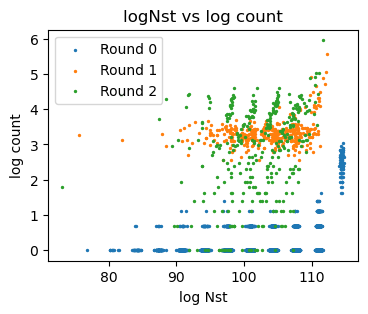

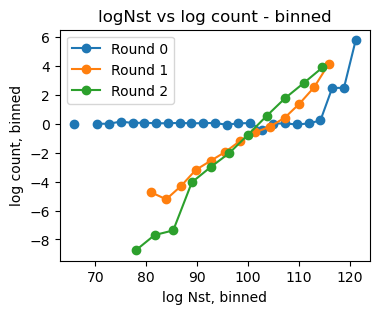

In [361]:
utils.binned_logcounts(model, sequences_unique_all_oh, counts_unique, n_bins = 25, plot=True, thresh=0.0);